# Collaborative Filtering Recommendation Engine

Who better to ask for a recommendation from than someone who has the same taste in books? This recommendation engine compares the similarity in users ratings in order to predict other books they'll like.

We'll be using the scikit-surprise library which is designed specifically for building and evaluating recommendation engines. More information can be found at http://surpriselib.com/ .

# Models that will be compared

## Basic Algorithms:

### NormalPredictor

This predicts a random rating based on the distribution of the training set, which is assumed to be normal. Not much is calculated here.

### BaselineOnly

This predicts the baseline estimate for given user and item.

* r̂_ui = b_ui = μ + b_u + b_i

* If user u is unknown, then the bias b_u is assumed to be zero. The same applies for item i with b_i.

# Matrix Factorization-based algorithms:

### SVD

SVD algorithm is equivalent to Probabilistic Matrix Factorization and famously used to win the Netflix prize.

The prediction r̂_ui is set as:

r̂_ui=μ+bu+bi+qTipu  
If user u is unknown, then the bias bu and the factors pu are assumed to be zero. The same applies for item i with bi and qi.

### NMF

NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It's similar to SVD.

# Evaluating the models
* The users were segmented into lox volume (< 65 books reviewed) and very high volume (>115 boos reviewd).
* GridSearch cross validation was used to tune parameters for models on both user segments. 

# Overview of results:
* The **BaselineOnly** algorithm performed best on low volume users with RMSE =  **0.8649**.
* The **SVD** algorithm performed best on low volume users with RMSE =  **0.8424**.
* When 

In [15]:
import pandas as pd
import numpy as np
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt

from surprise import Dataset, Reader
from surprise import NMF, SVD, KNNWithMeans, SVDpp, NormalPredictor, BaselineOnly, SlopeOne
from surprise import dump
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from surprise import accuracy

# Import progress bar for longer running model training
from tqdm import tnrange, tqdm_notebook
from time import sleep

## Read in data

In [17]:
df_books_metadata = pd.read_pickle('datasets/clean/books_with_genres.pkl')
df_ratings = pd.read_csv( 'datasets/raw/ratings_raw.csv' )

In [3]:
# Reminder of what the DF looks like
df_ratings.head(2)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4


## Train-Test-Validation Split

We'll use 80% of the data for training, 10% for testing, and set aside the last 10% for validation to be used when we build the final model.

In [4]:
# train-test split by randomly split on 'df_ratings' dataset (on user-book rating combination)
idx = list(df_ratings.index)
np.random.seed(9)
np.random.shuffle(idx) # shuffle the list of index

# 80% trainset, 10% testset, 10% validation (valset)
lower_threshold = int(0.8 * len(df_ratings)) 
upper_threshold = int(0.9 * len(df_ratings)) 
all_trainset = df_ratings.loc[idx[:lower_threshold]]                             
all_testset = df_ratings.loc[idx[lower_threshold:upper_threshold]]
all_valset = df_ratings.loc[idx[upper_threshold:]]

print("# of users in total:" , df_ratings.user_id.nunique())
print("# of users in the training set: ", all_trainset.user_id.nunique())
print("# of books in total:" , df_ratings.book_id.nunique())
print("# of books in the training set: ", all_trainset.book_id.nunique())
print("% of books in the training, testing and validation sets: ",
      round(len(all_trainset)/len(df_ratings)), round(len(all_testset)/len(df_ratings)), 
      round(len(all_valset)/len(df_ratings)))

# of users in total: 53424
# of users in the training set:  53424
# of books in total: 10000
# of books in the training set:  10000
% of books in the training, testing and validation sets:  1 0 0


## Matrix factorization using scikit-surprise package

## Prepare the dataset

In [5]:
# load trainset and testset into Surprise

# create a Reader object with the rating_scale from 1 to 5
reader = Reader(rating_scale=(1, 5))

# load trainset, note: 
#    the columns must correspond to user id, item id and ratings in the exact order
data_train = Dataset.load_from_df(all_trainset, reader)
# prepare a trainset object out of the training data to feed to .fit() method
training = data_train.build_full_trainset()


# load testset
data_test = Dataset.load_from_df(all_testset, reader)
# prepare a testset object out of the test data to feed to .test() method
testing = data_test.construct_testset(data_test.raw_ratings)


# Basic Algorithms:

### NormalPredictor & BaselineOnly
* **NormalPredictor** is a random generator based on the distirbution of the training set.
* **BaselineOnly** gives estimates using Alternating Least Squares (ALS)


In [6]:
%%time
# NormalPredictor model
norm = NormalPredictor() # initiate a NormalPredictor algorithm object
norm.fit(training) # training on the trainset
pred_norm = norm.test(testing) # predict ratings for the testset
print("Normal Predictor RMSE:", accuracy.rmse(pred_norm), '\n') # compute RMSE score

# BaselineOnly model with Alternating Least Squares (ALS)
base = BaselineOnly(bsl_options={}) # initiate a BaselineOnly algorithm object
base.fit(training) # training on the trainset
pred_base = base.test(testing) # predict ratings for the testset
print("Baseline RMSE:", accuracy.rmse(pred_base), '\n') # compute RMSE score


RMSE: 1.3223
Normal Predictor RMSE: 1.3223107662250975 

Estimating biases using als...
RMSE: 0.8549
Baseline RMSE: 0.8549264913336122 

CPU times: user 51.2 s, sys: 1.14 s, total: 52.3 s
Wall time: 53.2 s


# Split data into smaller sets to speed up model testing time.

In [15]:
#Examine User rating stats. To be used later.
user_stats_all = df_ratings.groupby('user_id')['rating'].agg(['mean', 'count', 'var'])
user_stats_80 = all_trainset.groupby('user_id')['rating'].agg(['mean', 'count', 'var'])
all_v_80_user_stats= pd.concat([user_stats_all['count'].describe(), 
                                  user_stats_80['count'].describe()], axis=1,)
all_v_80_user_stats.columns=['users_all', 'users_80_percent']
all_v_80_user_stats

,users_all,users_80_percent
count,53424.000000,53424.000000
mean,111.868804,89.495040
std,26.071224,21.254752
min,19.000000,13.000000
25%,96.000000,76.000000
50%,111.000000,89.000000
75%,128.000000,103.000000
max,200.000000,173.000000


In [16]:
# Create groups of users based on number of books rated (low, med, high, very high)
low_vol_users = user_stats_80[user_stats_80['count'] <= 65]
med_vol_users = user_stats_80[(user_stats_80['count'] > 65) & 
                              (user_stats_80['count'] <= 89)]
high_vol_users = user_stats_80[(user_stats_80['count'] > 89) & 
                               (user_stats_80['count'] <= 115)]
v_high_vol_users = user_stats_80[user_stats_80['count'] > 115]

print('Number of users with 1-75 ratings:', len(low_vol_users))
print('Number of users with 75-89 ratings:', len(med_vol_users))
print('Number of users with 89-105 ratings:', len(high_vol_users))
print('Number of users with 105-200 ratings:', len(v_high_vol_users))


Number of users with 1-75 ratings: 5705
Number of users with 75-89 ratings: 21919
Number of users with 89-105 ratings: 19893
Number of users with 105-200 ratings: 5907


## Low volume raters

In [17]:
low_vol_ratings = all_trainset[all_trainset.user_id.isin(low_vol_users.index)]
low_vol_ratings.head(1)

,user_id,book_id,rating
2772613,13816,7434,5


In [25]:
def load_and_split_data(df):
    '''Load pandas dataframe into the correct format to be used in the Scikit Surprise package.
    NOTE: The df columns must correspond to 'user id', 'item id' and 'ratings', in that exact order'''
    from surprise import Dataset
    from surprise import Reader
    
    # train-test split by randomly split on 'df_ratings' dataset (on user-book rating combination)
    idx = list(df.index)
    np.random.seed(9)
    np.random.shuffle(idx) # shuffle the list of index

    # 90% trainset, 10% testset
    threshold = int(0.9 * len(df)) 
    trainset = df.loc[idx[:threshold]]                             
    testset = df.loc[idx[threshold:]]

    # create a Reader object with the rating_scale from 1 to 5
    reader = Reader(rating_scale=(1, 5))
    
    # load trainset, note: 
    #    the columns must correspond to user id, item id and ratings in the exact order
    data_train = Dataset.load_from_df(trainset, reader)
    # prepare a trainset object out of the training data to feed to .fit() method
    training = data_train.build_full_trainset()


    # load testset
    data_test = Dataset.load_from_df(testset, reader)
    # prepare a testset object out of the test data to feed to .test() method
    testing = data_test.construct_testset(data_test.raw_ratings)
    
    return training, testing


In [31]:
# Split into train and test sets (90%/10%)
low_trainset, low_testset = load_and_split_data(low_vol_ratings)

In [20]:
# Define function to load data into Surprise format

def load_data(df):
    '''Load pandas dataframe into the correct format to be used in the Scikit Surprise package.
    NOTE: The df columns must correspond to 'user id', 'item id' and 'ratings', in that exact order'''
    from surprise import Dataset
    from surprise import Reader

    # create a Reader object with the rating_scale from 1 to 5
    reader = Reader(rating_scale=(1, 5))
    
    # load dataset
    data = Dataset.load_from_df(df, reader=reader)
    
    return data


In [30]:
# Load the data
low_data = load_data(low_vol_ratings)

# Split into train and test sets (90%/10%)
low_trainset2, low_testset2 = train_test_split(low_data, test_size=.10)


## Low volume raters - Baseline, SVD, and NMF
* Baseline: 
  - **RMSE = 0.8649** *(Best)*
* SVD:
  - Best parameters = {'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.1}
  - RMSE = 0.8678
* NMF:
  - Best parameters = {'n_factors': 10, 'n_epochs': 25, 'biased': True}
  - RMSE = 0.8694

### Low Volume Baseline

In [37]:
%%time
# NormalPredictor model
norm = NormalPredictor() # initiate a NormalPredictor algorithm object
norm.fit(low_trainset2) # training on the trainset
pred_norm = norm.test(low_testset2) # predict ratings for the testset
print("Normal Predictor RMSE:", accuracy.rmse(pred_norm), '\n') # compute RMSE score

# BaselineOnly model
base = BaselineOnly() # initiate a BaselineOnly algorithm object
base.fit(low_trainset2) # training on the trainset
pred_base = base.test(low_testset2) # predict ratings for the testset
print("Baseline RMSE:", accuracy.rmse(pred_base), '\n') # compute RMSE score

RMSE: 1.3299
Normal Predictor RMSE: 1.3298526373465813 

Estimating biases using als...
RMSE: 0.8649
Baseline RMSE: 0.8649029588501963 

CPU times: user 3.59 s, sys: 3.37 s, total: 6.96 s
Wall time: 8.89 s


### Low Vol SVD with CV
* n_epochs – The number of iteration of the SGD procedure. Default is 20.
* lr_all – The learning rate for all parameters. Default is 0.005.
* reg_all – The regularization term for all parameters. Default is 0.02.

In [35]:
%%time
# Tuning SVD model

param_grid = {'n_epochs': [15, 20], 'lr_all': [0.001, .005, 1],
              'reg_all': [0.1, 0.2, 0.4]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(low_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8691116272167974
{'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.1}
CPU times: user 9min 58s, sys: 6.04 s, total: 10min 4s
Wall time: 10min 17s


In [36]:
%%time
# Tuning SVD model

param_grid = {'n_epochs': [20, 25], 'lr_all': [0.005, 0.1],
              'reg_all': [0.005, 0.1, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(low_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8677905130832632
{'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.1}
CPU times: user 14min 41s, sys: 4.41 s, total: 14min 45s
Wall time: 4h 5min 22s


In [102]:
%%time
# SVD model with bias
svd = SVD(n_epochs = 15, lr_all= .005, reg_all=.2) # initiate a SVD algorithm object
svd.fit(low_trainset) # training on the trainset
pred_svd = svd.test(low_testset) # predict ratings for the testset
accuracy.rmse(pred_svd) # compute RMSE score

# user and item matrix with latent features
user_latent, item_latent = svd.pu, svd.qi
print(user_latent.shape, item_latent.shape)
# biased/no biased, n_epoch=15, n_factor=100 RMSE: 0.8577
# no biased, n_epoch=20 n_factor=100, RMSE: 0.8572
# n_factors=50 RMSE: 0.8574

RMSE: 0.8574
(12673, 50) (10000, 50)
CPU times: user 25.6 s, sys: 37.3 ms, total: 25.6 s
Wall time: 25.6 s


### Low Vol NMF
* n_factors – The number of factors. Default is 15.
* n_epochs – The number of iteration of the SGD procedure. Default is 50.
* biased (bool) – Whether to use baselines (or biases). Default is False.

In [44]:
%%time
# Tuning NMF model

param_grid = {'n_factors': [10, 15], 'n_epochs': [15, 20, 25],
              'biased': [True, False]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(low_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.869370924436538
{'n_factors': 10, 'n_epochs': 25, 'biased': True}
CPU times: user 9min 38s, sys: 4.49 s, total: 9min 43s
Wall time: 9min 54s


## Very high volume raters - Baseline, SVD, and NMF
* Baseline: 
  - RMSE = 0.8523
* SVD:
  - Best parameters = {'n_epochs': 45, 'lr_all': 0.005, 'reg_all': 0.1, 'biased': True}
  - **RMSE = 0.8424** *(Best)*
* NMF:
  - Best parameters = {'n_factors': 10, 'n_epochs': 25, 'biased': True}
  - RMSE = 0.8575

In [48]:
v_high_vol_ratings = df_ratings[df_ratings.user_id.isin(v_high_vol_users.index)]

# Load the data
hi_data = load_data(v_high_vol_ratings)

# Split into train and test sets (90%/10%)
hi_trainset2, hi_testset2 = train_test_split(hi_data, test_size=.10)

# Using 2nd method - Split into train and test sets (90%/10%)
low_trainset, low_testset = load_and_split_data(low_vol_ratings)

### High Vol Baseline

In [49]:
%%time
# NormalPredictor model
norm = NormalPredictor() # initiate a NormalPredictor algorithm object
norm.fit(hi_trainset2) # training on the trainset
pred_norm = norm.test(hi_testset2) # predict ratings for the testset
print("Normal Predictor RMSE:", accuracy.rmse(pred_norm), '\n') # compute RMSE score

# BaselineOnly model
base = BaselineOnly() # initiate a BaselineOnly algorithm object
base.fit(hi_trainset2) # training on the trainset
pred_base = base.test(hi_testset2) # predict ratings for the testset
print("Baseline RMSE:", accuracy.rmse(pred_base), '\n') # compute RMSE score

RMSE: 1.3376
Normal Predictor RMSE: 1.337604224173024 

Estimating biases using als...
RMSE: 0.8523
Baseline RMSE: 0.8522591744494993 

CPU times: user 7.19 s, sys: 393 ms, total: 7.58 s
Wall time: 7.58 s


### Hi Vol SVD

In [50]:
%%time
# Tuning SVD model

param_grid = {'n_epochs': [20, 25], 'lr_all': [0.005, 0.1],
              'reg_all': [0.005, 0.1, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(hi_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.8534054441946447
{'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.1}
CPU times: user 32min 58s, sys: 8.86 s, total: 33min 7s
Wall time: 43min 50s


In [53]:
%%time
# Tuning SVD model

param_grid = {'n_epochs': [25, 30, 45], 'lr_all': [0.005],
              'reg_all': [0.1], 'biased': [True, False]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(hi_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



0.8423944567780013
{'n_epochs': 45, 'lr_all': 0.005, 'reg_all': 0.1, 'biased': True}
CPU times: user 23min 50s, sys: 11.1 s, total: 24min 1s
Wall time: 34min 20s


### Hi Vol NMF

In [51]:
%%time
# Tuning NMF model

param_grid = {'n_factors': [10, 15], 'n_epochs': [15, 20, 25],
              'biased': [True, False]}
nmf = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=5)

nmf.fit(hi_data)

# best RMSE score
print(nmf.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(nmf.best_params['rmse'])

0.8574896682980133
{'n_factors': 10, 'n_epochs': 25, 'biased': True}
CPU times: user 24min 35s, sys: 7.69 s, total: 24min 42s
Wall time: 24min 51s


In [52]:
# best RMSE score
print(gs.best_score['mae'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['mae'])


0.6719527507360902
{'n_factors': 10, 'n_epochs': 25, 'biased': True}


In [23]:
%%time
# simple NMF model
nmf = NMF(n_factors=20, n_epochs = 30, biased=False) # initiate a NMF algorithm object
nmf.fit(training) # training on the trainset
pred_nmf = nmf.test(testing) # predict ratings for the testset
accuracy.rmse(pred_nmf) # compute RMSE score

# user and item matrix with latent features
mean = nmf.trainset.global_mean # global mean rating of the trainset
user_latent, item_latent = nmf.pu, nmf.qi
print(user_latent.shape, item_latent.shape)

RMSE: 0.9324
(4011, 20) (9655, 20)
CPU times: user 29.7 s, sys: 122 ms, total: 29.8 s
Wall time: 30.3 s


In [24]:
%%time
# SVD model with bias
svd = SVD(n_factors=20, n_epochs = 30, biased=True) # initiate a SVD algorithm object
svd.fit(training) # training on the trainset
pred_svd = svd.test(testing) # predict ratings for the testset
accuracy.rmse(pred_svd) # compute RMSE score

# user and item matrix with latent features
mean = svd.trainset.global_mean # global mean rating of the trainset
user_latent, item_latent = svd.pu, svd.qi
print(user_latent.shape, item_latent.shape)

RMSE: 0.8498
(4011, 20) (9655, 20)
CPU times: user 23.6 s, sys: 25.5 ms, total: 23.6 s
Wall time: 23.7 s


# 2. Fit best models on full dataset (without validation set)
* **Models**: SVD and BaselineOnly with ALS
* **Accuracy metrics**:
  * RMSE (Root Mean Squared Error)
  * MAE (Mean Absolute Error) - MAE isn't affected as strongly as RMSE when there are a few large errors skewing the model's accuracy.
  * FCP (Fraction of Concordant Pairs) - This measures the proportion of well ranked items pairs. It generalizes the known AUC metric into nonbinary ordered outcomes. Unlike with RMSE and MAE, a higher FCP score is better. More information can be found here: https://www.ijcai.org/Proceedings/13/Papers/449.pdf

In [5]:
%%time

# SVD model with bias

# initiate a SVD algorithm object
svd = SVD(n_factors=20, n_epochs = 45, lr_all= 0.005, reg_all=0.1, biased=True)
svd.fit(training) # training on the trainset
pred_svd = svd.test(testing) # predict ratings for the testset
accuracy.rmse(pred_svd) # compute RMSE score

# user and item matrix with latent features
user_latent, item_latent = svd.pu, svd.qi
print(user_latent.shape, item_latent.shape)

RMSE: 0.8444
(53424, 20) (10000, 20)
CPU times: user 6min 24s, sys: 4.52 s, total: 6min 29s
Wall time: 6min 41s


In [10]:
accuracy.rmse(pred_svd), accuracy.mae(pred_svd), accuracy.fcp(pred_svd)

RMSE: 0.8444
MAE:  0.6612
FCP:  0.6473


(0.8444307299015412, 0.6612015055437588, 0.6473083422165642)

In [8]:
%%time

# Baseline model

# BaselineOnly model
base = BaselineOnly() # initiate a BaselineOnly algorithm object
base.fit(training) # training on the trainset
pred_base = base.test(testing) # predict ratings for the testset
accuracy.rmse(pred_base) # compute RMSE score

Estimating biases using als...
RMSE: 0.8549
CPU times: user 25.1 s, sys: 3.07 s, total: 28.2 s
Wall time: 28.7 s


In [11]:
accuracy.rmse(pred_base), accuracy.mae(pred_base), accuracy.fcp(pred_base)

RMSE: 0.8549
MAE:  0.6713
FCP:  0.6355


(0.8549264913336122, 0.6713463531361373, 0.635457155330577)

In [12]:
# Save models and predictions
dump.dump('./dump_SVD', pred_svd, svd)
dump.dump('./dump_Baseline', pred_base, base)

# 3. Evaluate model performance on edge cases
* Evaluation metrics: RMSE, MAE, FCP
* Edge cases: low volume and high volume users, new users

In [13]:
# The dumps have been saved and we can now use them whenever we want.

predictions_svd, algo_svd = dump.load('./dump_SVD')
predictions_base, algo_base = dump.load('./dump_Baseline')

df_svd = pd.DataFrame(predictions_svd, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_base = pd.DataFrame(predictions_base, columns=['uid', 'iid', 'rui', 'est', 'details'])    

df_svd['err'] = abs(df_svd.est - df_svd.rui)
df_base['err'] = abs(df_base.est - df_base.rui)

In [19]:
print(df_svd[['est', 'err']].describe())
print(df_base[['est', 'err']].describe())

                 est            err
count  597648.000000  597648.000000
mean        3.920074       0.661202
std         0.472399       0.525239
min         1.000000       0.000000
25%         3.610221       0.261185
50%         3.923951       0.556506
75%         4.241006       0.933538
max         5.000000       4.000000
                 est            err
count  597648.000000  597648.000000
mean        3.918778       0.671346
std         0.461243       0.529333
min         1.000000       0.000000
25%         3.614012       0.267302
50%         3.922763       0.568170
75%         4.232568       0.945885
max         5.000000       4.000000


In [23]:
# Let's check how good the baseline predictions are when the SVD has a huge error:
df_base[df_svd.err >= 3.5].head(10)

,uid,iid,rui,est,details,err
1676,35270,129,1.0,4.641006,{'was_impossible': False},3.641006
5242,52963,1160,1.0,4.466319,{'was_impossible': False},3.466319
8142,35461,591,1.0,4.609648,{'was_impossible': False},3.609648
8704,28870,8638,1.0,5.000000,{'was_impossible': False},4.000000
12604,38261,161,1.0,4.689008,{'was_impossible': False},3.689008
13044,35346,304,1.0,4.509022,{'was_impossible': False},3.509022
17590,18569,1998,1.0,4.676717,{'was_impossible': False},3.676717
21957,29174,267,1.0,4.920137,{'was_impossible': False},3.920137
24960,43569,449,1.0,4.448783,{'was_impossible': False},3.448783
25591,51983,16,1.0,5.000000,{'was_impossible': False},4.000000


In [24]:
# Well... Not much better.
# Now, let's look at the predictions of SVD on the 10 worst predictions for Baseline
df_svd.iloc[df_base.sort_values(by='err')[-10:].index]

,uid,iid,rui,est,details,err
25591,51983,16,1.0,5.000000,{'was_impossible': False},4.000000
431455,31335,250,1.0,5.000000,{'was_impossible': False},4.000000
224921,52683,23,1.0,4.931273,{'was_impossible': False},3.931273
206705,35283,3736,1.0,5.000000,{'was_impossible': False},4.000000
248111,30070,7,1.0,5.000000,{'was_impossible': False},4.000000
61163,39979,1628,1.0,5.000000,{'was_impossible': False},4.000000
307723,31126,4,1.0,4.868325,{'was_impossible': False},3.868325
235903,29130,50,1.0,4.956565,{'was_impossible': False},3.956565
280860,32574,8606,1.0,5.000000,{'was_impossible': False},4.000000
8704,28870,8638,1.0,5.000000,{'was_impossible': False},4.000000


<IPython.core.display.Javascript object>


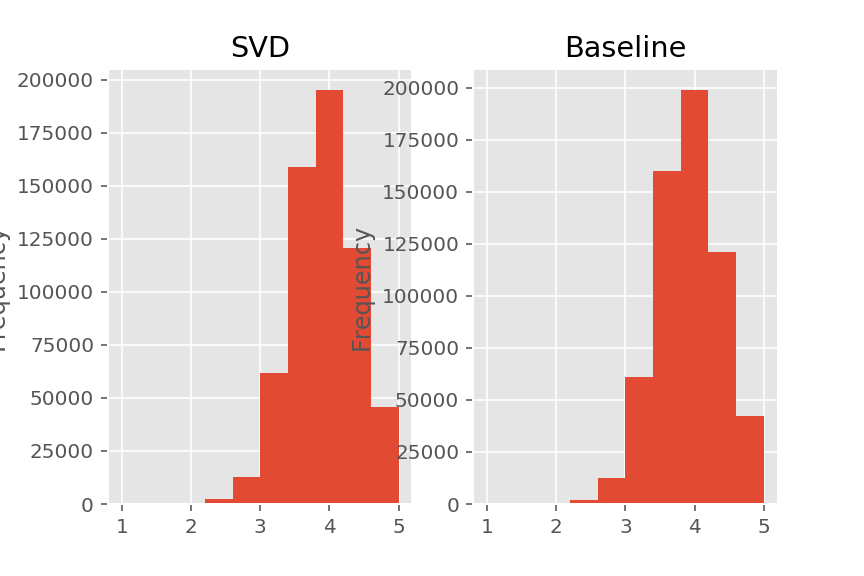

In [28]:
# How different are the predictions from both algorithms ?
# Let's count the number of predictions for each rating value

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

figure, (ax1, ax2) = plt.subplots(1, 2)

df_svd.est.plot(kind='hist', title='SVD', ax=ax1)
df_base.est.plot(kind='hist', title='Baseline', ax=ax2)
plt.show()

#The prediction distributions look identical.

In [31]:
# Question: when a user has rated only a small number of items (less than 20), which algorithm
# gives the best predictions on average?

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(training.ur[training.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
df_base['Iu'] = df_base.uid.apply(get_Iu)
df_svd['Iu'] = df_svd.uid.apply(get_Iu)

df_base[df_base.Iu < 20].err.mean(), df_svd[df_svd.Iu < 20].err.mean()

# SVD has slightly better predictions when a user hasn't rated many books yet.

(0.7985629109268277, 0.7974379161179959)

# 4. Build recommendation engine

In [43]:
# View metadata for books.
df_books_metadata.head(2)

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,...,realistic-fiction,reference,religion,romance,science,science-fiction,self-help,short-stories,travel,young-adult
0,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,...,0.0,0.0,0.0,0.06706,0.0,0.17607,0.0,0.0,0.0,0.521226
1,2,3,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.211489


In [33]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
#data = Dataset.load_builtin('ml-100k')
#trainset = data.build_full_trainset()
#algo = SVD()
#algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
#testset = trainset.build_anti_testset()
#predictions = algo.test(testset)

top_n = get_top_n(pred_svd, n=10)

# Print the recommended items for each user
#for uid, user_ratings in top_n.items():
#    print(uid, [iid for (iid, _) in user_ratings])

In [37]:
# Print the recommended items for user id = 7
top_n[7] 

[(4726, 4.152995348169892),
 (1337, 4.099913152059567),
 (1519, 4.085105026369514),
 (13, 4.084843160954971),
 (89, 4.059438852211656),
 (2782, 4.042178429505025),
 (416, 3.966570125091063),
 (2189, 3.8531225309427466),
 (116, 3.836631239216342),
 (1620, 3.8108262487371936)]

In [18]:
recommended_list = [(4726, 4.152995348169892),
 (1337, 4.099913152059567),
 (1519, 4.085105026369514),
 (13, 4.084843160954971),
 (89, 4.059438852211656),
 (2782, 4.042178429505025),
 (416, 3.966570125091063),
 (2189, 3.8531225309427466),
 (116, 3.836631239216342),
 (1620, 3.8108262487371936)]

for book in recommended_list:
    book
    indx = book[0]-1
    print(df_books_metadata.loc[indx, ['title','authors']])


title      A Deepness in the Sky (Zones of Thought, #2)
authors                                    Vernor Vinge
Name: 4725, dtype: object
title      Going Postal (Discworld, #33; Moist von Lipwig...
authors                                      Terry Pratchett
Name: 1336, dtype: object
title      The Diamond Age: or, A Young Lady's Illustrate...
authors                                      Neal Stephenson
Name: 1518, dtype: object
title                                         1984
authors    George Orwell, Erich Fromm, Celâl Üster
Name: 12, dtype: object
title      The Princess Bride 
authors        William Goldman
Name: 88, dtype: object
title      Transmetropolitan, Vol. 1: Back on the Street ...
authors         Warren Ellis, Darick Robertston, Garth Ennis
Name: 2781, dtype: object
title                    The Witches
authors    Roald Dahl, Quentin Blake
Name: 415, dtype: object
title      The Ghost Brigades (Old Man's War, #2)
authors                               John Scalzi
Name: 2

# 5. Conclusion
* Insights
* Limitations
* Future considerations


## (Reference only) A few other models without cross-validation

## NMF (non-negative matrix factorization) without bias term

In [32]:
%%time
# simple NMF model
nmf = NMF(n_factors=20, n_epochs = 30, biased=False) # initiate a NMF algorithm object
nmf.fit(training) # training on the trainset
pred_nmf = nmf.test(testing) # predict ratings for the testset
accuracy.rmse(pred_nmf) # compute RMSE score

# user and item matrix with latent features
mean = nmf.trainset.global_mean # global mean rating of the trainset
user_latent, item_latent = nmf.pu, nmf.qi
print(user_latent.shape, item_latent.shape)

RMSE: 0.9179
(53424, 20) (10000, 20)
CPU times: user 5min 9s, sys: 9.72 s, total: 5min 18s
Wall time: 5min 25s


In [14]:
%%time
# simple NMF model
nmf = NMF(n_factors=20, n_epochs = 30, biased=True) # initiate a NMF algorithm object
nmf.fit(training) # training on the trainset
pred_nmf = nmf.test(testing) # predict ratings for the testset
accuracy.rmse(pred_nmf) # compute RMSE score

# user and item matrix with latent features
mean = nmf.trainset.global_mean # global mean rating of the trainset
user_latent, item_latent = nmf.pu, nmf.qi
print(user_latent.shape, item_latent.shape)

RMSE: 0.9489
(53424, 20) (10000, 20)
CPU times: user 4min 55s, sys: 2.3 s, total: 4min 58s
Wall time: 5min 3s


## SVD without bias

This is the best model out of the box with a rmse of 0.8256

In [7]:
%%time
# simple SVD model
svd2 = SVD(n_factors=20, n_epochs = 30, biased=False) # initiate a SVD algorithm object
svd2.fit(training) # training on the trainset
pred_svd2 = svd2.test(testing) # predict ratings for the testset
accuracy.rmse(pred_svd2) # compute RMSE score

# user and item matrix with latent features
user_latent2, item_latent2 = svd2.pu, svd2.qi
print(user_latent2.shape, item_latent2.shape)

RMSE: 0.8262
(53424, 20) (10000, 20)
CPU times: user 4min 7s, sys: 3.02 s, total: 4min 10s
Wall time: 4min 15s


## SVD with bias

In [33]:
%%time
# SVD model with bias
svd = SVD(n_factors=20, n_epochs = 30, biased=True) # initiate a SVD algorithm object
svd.fit(training) # training on the trainset
pred_svd = svd.test(testing) # predict ratings for the testset
accuracy.rmse(pred_svd) # compute RMSE score

# user and item matrix with latent features
mean = svd.trainset.global_mean # global mean rating of the trainset
user_latent, item_latent = svd.pu, svd.qi
print(user_latent.shape, item_latent.shape)

RMSE: 0.8291
(53424, 20) (10000, 20)
CPU times: user 4min 22s, sys: 7.84 s, total: 4min 30s
Wall time: 4min 36s
